Contributors: 
Peter Harmer,
Girish Dodda

In [2]:
%pip install pandas

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\giris\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [28]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import Counter
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
import re

In [5]:
#Initializing
gpu_available = torch.cuda.is_available()
if gpu_available:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("GPU available: {}".format(gpu_available))

GPU available: False


In [17]:
#Load & check Data

colab = False

if colab:
    from google.colab import drive
    drive.mount('/content/drive')
    data = pd.read_csv('drive/My Drive/COMP SCI 539/bbc-news-data.csv', delimiter='\t')
else:
    data = pd.read_csv('bbc-news-data.csv', delimiter='\t')

data.head()

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


category    0
filename    0
title       0
content     0
dtype: int64


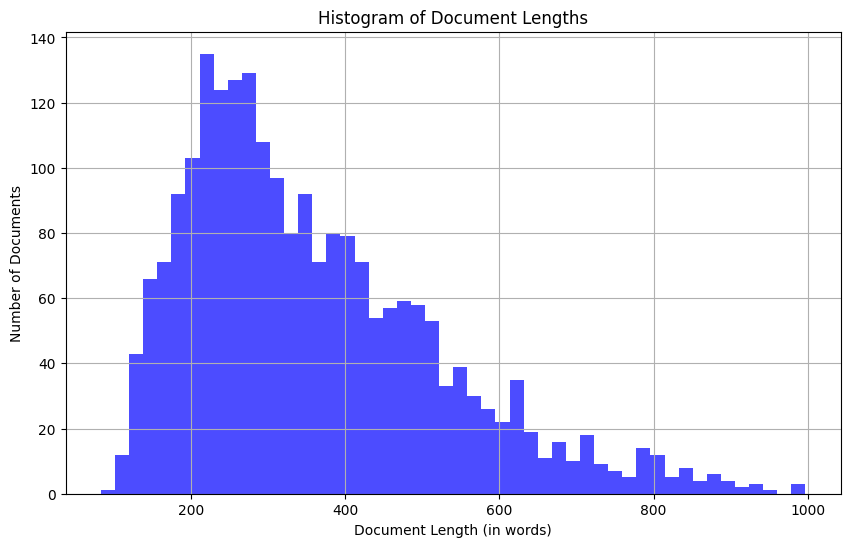

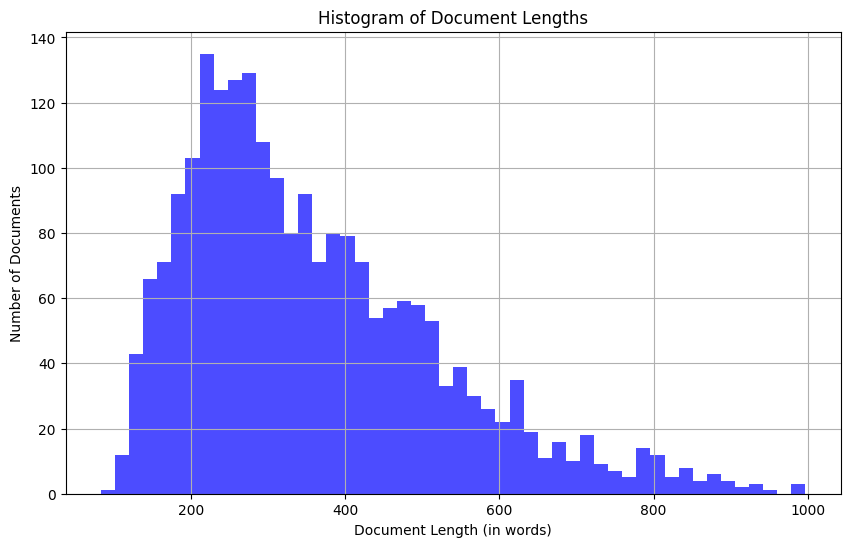

In [23]:
#Data Preprocessing

# Find and remove nulls
print(data.isnull().sum())

# Data to lowercase
data["title"] = data["title"].str.lower()
data["content"] = data["content"].str.lower()
# Remove and replace contractions
#Find more contraction in text and add
contraction_dict = {"can't":"cannot","didn't":"did not","aren't":"are not","she'd":"she would","he'd":"he would","they'd":"they would","they've":"they have",
"shouldn't":"should not","shouldn't've":"should not have","she'll":"she will","he'll":"he will","they'll":"they will"
}

def contraction_replacer(text):
    for word in text.split():
        if word in contraction_dict:
            text = text.replace(word, contraction_dict[word])
    return text

data["title"] = data["title"].apply(contraction_replacer)
data["content"] = data["content"].apply(contraction_replacer)

# Remove punctuation and numbers
#Find more punctuation in text and add

punctuation_numbers = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~0123456789'

def punctuation_numbers_remover(text):
    for punctuation in punctuation_numbers:
        text = text.replace(punctuation, '')
    return text

data["title"] = data["title"].apply(punctuation_numbers_remover)
data["content"] = data["content"].apply(punctuation_numbers_remover)

data.head()

# plot the distribution of the lengths of the sequences
content_lengths = [len(content.split()) for content in data["content"]]


plt.figure(figsize=(10, 6))  # Set the size of the plot
plt.hist(content_lengths, bins=50, color='blue',
         alpha=0.7)  # Adjust bins as needed
plt.title('Histogram of Document Lengths')
plt.xlabel('Document Length (in words)')
plt.ylabel('Number of Documents')
plt.grid(True)
plt.show()

# remove the outliers
MAX_CONTENT_LENGTH = 1000
MAX_TITLE_LENGTH = 10
# get the indices of the documents that have more than 1000 words
outliers = [idx for idx, length in enumerate(
    content_lengths) if length > MAX_CONTENT_LENGTH]

# remove the outliers from the data
data = data.drop(outliers, axis=0).reset_index(drop=True)

# plot the distribution of the lengths of the sequences
content_lengths = [len(content.split()) for content in data["content"]]
plt.figure(figsize=(10, 6))  # Set the size of the plot
plt.hist(content_lengths, bins=50, color='blue',
         alpha=0.7)  # Adjust bins as needed
plt.title('Histogram of Document Lengths')
plt.xlabel('Document Length (in words)')
plt.ylabel('Number of Documents')
plt.grid(True)
plt.show()

In [24]:
SOS_token = 0
EOS_token = 1


class Vocab:
    def __init__(self):
        self.word2index = {"PAD": 0, "SOS": 1, "EOS": 2, "UNK": 3}
        self.index2word = {0: "PAD", 1: "SOS", 2: "EOS", 3: "UNK"}
        self.word2count = {}
        self.n_words = 4  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

    def tokenize(self, sentence, seq_len=None):
        # Add Start Of Sentence token
        token_seq_idx = [self.word2index["SOS"]]

        # Tokenize each word in sentence
        for tkn in sentence.split():
            token_seq_idx.append(
                self.word2index[tkn if tkn in self.word2index else "UNK"])

        # Add End Of Sentence token
        token_seq_idx.append(self.word2index["EOS"])

        if seq_len is not None:
            if len(token_seq_idx) < seq_len:
                # Pad to desired length
                token_seq_idx += [self.word2index["PAD"]] * \
                    (seq_len - len(token_seq_idx))
            else:
                # Trim sentence to length
                token_seq_idx = token_seq_idx[:seq_len]

        return token_seq_idx

    def list2sentence(self, seq_ids):
        return " ".join([self.index2word[idx] for idx in seq_ids])


print("Creating vocab...")
vocab = Vocab()
for content in data["content"]:
    vocab.addSentence(content)

# Test it out
print("Number of words in vocab: {}".format(vocab.n_words))
# pick a random sequence from the data
random_idx = np.random.randint(0, len(data))
print("Original text: {}".format(data["content"][random_idx]))
# tokenize the text
tokenized_text = vocab.tokenize(data["content"][random_idx])
print("Tokenized text: {}".format(tokenized_text))
# convert back to text
converted_text = vocab.list2sentence(tokenized_text)
print("Converted text: {}".format(converted_text))

Creating vocab...
Number of words in vocab: 31563
Original text:  malaysia's central bank is to relax restrictions on foreign ownership to encourage islamic banking  banks in malaysia will now be able to sell up to  of their islamic banking units while the limit on other kinds of bank remains at  rhb malaysia's thirdbiggest lender is already scouting for a foreign partner for its new islamic banking unit the firm told reuters the moves put malaysia ahead of a  deadline to open up the sector the country's deal to join the world trade organisation set that year as a deadline for liberalisation of islamic banking also on tuesday the central bank released growth figures showing malaysia's economy expanded  in  but growth slowed sharply in the fourth quarter to  and the central bank said it expected  expansion in   malaysia changed the law to allow islamic banking in  it has granted licences to three middle eastern groups which  along with local players  mean there are eight fullyoperationa

In [29]:
def create_dataloaders(batch_size):
    # Create two huge tensor with all english and french sentences
    n = len(data)
    print("Creating dataloaders with {} samples...".format(n))
    content_seqs_ids = torch.zeros((n, MAX_CONTENT_LENGTH+2)).long()
    title_seqs_ids = torch.zeros((n, MAX_TITLE_LENGTH+2)).long()

    for idx, content in enumerate(data["content"]):
        # Tokenize and add to tensor
        content_seqs_ids[idx] = torch.tensor(
            vocab.tokenize(content, seq_len=MAX_CONTENT_LENGTH+2))
        
    for idx, title in enumerate(data["title"]):
        title_seqs_ids[idx] = torch.tensor(
            vocab.tokenize(title, seq_len=MAX_TITLE_LENGTH+2))

    # Split into training and testing
    train_sample_mask = torch.rand((n,)) > 0.3

    train_content_seqs_ids = content_seqs_ids[train_sample_mask]
    train_title_seqs_ids = title_seqs_ids[train_sample_mask]
    test_content_seqs_ids = content_seqs_ids[~train_sample_mask]
    test_title_seqs_ids = title_seqs_ids[~train_sample_mask]
    

    # Create train dataloader
    train_data = TensorDataset(train_content_seqs_ids.to(
        device), train_title_seqs_ids.to(device))
    train_dataloader = DataLoader(
        train_data, sampler=RandomSampler(train_data), batch_size=batch_size)

    # Create test dataloader
    test_data = TensorDataset(test_content_seqs_ids.to(
        device), test_title_seqs_ids.to(device))
    # test_dataloader = DataLoader(test_data, sampler=RandomSampler(train_data), batch_size=batch_size)
    return train_dataloader, test_data


# Test the dataloader
train_dataloader, test_data = create_dataloaders(32)
for cont, titl in train_dataloader:
    print('Batch | cont =', cont.shape, '| titl =', titl.shape)
    print('First content: ', vocab.list2sentence(cont[0].tolist()))
    print('First title:', vocab.list2sentence(titl[0].tolist()))
    break

Creating dataloaders with 2204 samples...
Batch | cont = torch.Size([32, 1002]) | titl = torch.Size([32, 12])
First content:  SOS the uk's biggest brewer scottish and newcastle sn is to buy of india's united breweries in a deal worth bn rupees m£m sn will buy a equity stake in united maker of the wellknown kingfisher lager brand and make a public offer to buy another stake a similar holding will be controlled by vijay mallya chair of the indian firm the deal was a natural development of its joint venture with united said tony froggatt sn's chief executive its top brands include newcastle brown ale foster's john smith's strongbow and kronenbourg in sn and united agreed to form a strategic partnership one that would include a joint venture business and a uk investment in the indian brewer the joint venture was established in may with both parties having a stake in the venture millennium alcobev millennium alcobev will now be merged with united which expects postmerger to have about half 

In [10]:
class Encoder(nn.Module):
  def __init__(self, input_size, output_size, hid_dim, emb_dim, n_layers, dropout):
    super().__init__()

    self.hid_dim = hid_dim
    self.n_layers = n_layers

    self.embedding = nn.Embedding(input_size,emb_dim)

    self.rnn = nn.RNN(input_size, hid_dim, n_layers, batch_first=True, dropout=dropout)

    self.dropout = nn.Dropout(dropout)

  def forward(self, input):
    print(input.shape)
    embedded = self.embedding(input)
    print(input.shape)
    print(input.dtype)
    embedded = self.dropout(input)
    print(embedded.shape)
    outputs, (hid_state, cell_state) = self.rnn(embedded)
    return hid_state , cell_state


class Decoder(nn.Module):
  def __init__(self, input_size, output_size, hid_dim, emb_dim, n_layers, dropout):
    super().__init__()

    self.out_size = output_size
    self.emb_dim = emb_dim
    self.hid_dim = hid_dim
    self.n_layers = n_layers

    self.embedding = self.embedding = nn.Embedding(output_size, emb_dim)

    self.rnn = nn.RNN(input_size, hid_dim, n_layers, batch_first=True, dropout=dropout)
    self.out = nn.Linear(hid_dim, output_size)

    self.dropout = nn.Dropout(dropout)

  def forward(self, input, hid_state, cell_state):

    input = input.unsqueeze(0)
    embedded = self.dropout(self.embedding(input))

    output, (hid_state, cell_state) = self.rnn(embedded,(hid_state, cell_state))

    result = self.out(output.squeeze(0))

    return result, hid_state, cell_state



In [11]:
#Recurrent Network Frame


""" Removed For Error Identification
#Encoder(input_size, hid_dim, hid_dim, emb_dim, n_layers, dropout),
      #nn.LSTM(hid_dim, hid_dim, n_layers, batch_first=True, dropout=dropout),
      self.layers = nn.Sequential(
      ,
      ,
      ,
      #nn.LSTM(hid_dim, hid_dim, n_layers, batch_first=True, dropout=dropout),
      #Decoder(hid_dim, output_size, hid_dim, emb_dim, n_layers, dropout),
    )

"""
class base_rnn(nn.Module):
    def __init__(self, input_size, output_size, hid_dim, n_layers, emb_dim, dropout, device):
        super().__init__()
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        #Initial setup
        self.device = device
        self.RNN_one = nn.LSTM(input_size, hid_dim, n_layers, batch_first=True, dropout=dropout).to(self.device)
        self.RNN_two = nn.LSTM(hid_dim, hid_dim, n_layers, batch_first=True, dropout=dropout).to(self.device)
        self.RNN_three = nn.LSTM(hid_dim, output_size, n_layers, batch_first=True, dropout=dropout).to(self.device)

    def forward(self, x):
      #batch_size = len(x)
      x = x.float()
      x = x.to(self.device)
      out, states  = self.RNN_one(x)
      out, states = self.RNN_two(out)
      out, states = self.RNN_three(out)
      return out

In [12]:
#Hyperparameters
dropout = 0.1
hidden_dim = 512
lr= 0.01
n_epochs = 20
summation_length = 10

# Test Values

#Input size
input_size = 10
#Output size
output_size = 10

In [13]:
#Testing for creation errors
model = base_rnn(input_size, output_size, hidden_dim, summation_length, vocab_size, dropout, device)
model

base_rnn(
  (RNN_one): LSTM(10, 512, num_layers=10, batch_first=True, dropout=0.1)
  (RNN_two): LSTM(512, 512, num_layers=10, batch_first=True, dropout=0.1)
  (RNN_three): LSTM(512, 10, num_layers=10, batch_first=True, dropout=0.1)
)

In [14]:
#output testing

#Hyperparameters
dropout = 0.1
hidden_dim = 512
lr= 0.01
n_epochs = 200
summation_length = 10

# test row
test_row = 6

#Input Data
input_corpus = corpus_processing(data, "content")

input_vocab_size = len(input_corpus) + 2
tkn_counter = Counter([word for word in input_corpus])
vocab = {word: idx for idx, (word, _) in enumerate(tkn_counter.most_common(input_vocab_size))}
vocab["/UNK"] = len(vocab)
vocab["/PAD"] = len(vocab)


# Output Data
output_corpus = corpus_processing(data, "title")

train_ratio = 0.8
split_idx = int(len(input_corpus) * train_ratio)

train_corpus_sum = input_corpus[:split_idx]
val_corpus_sum = input_corpus[split_idx:]

train_corpus_tar = output_corpus[:split_idx]
val_corpus_tar = output_corpus[split_idx:]


train_dataset = CorpusConversion(train_corpus_sum, train_corpus_tar , vocab, summation_length)
val_dataset = CorpusConversion(val_corpus_sum, train_corpus_tar, vocab, summation_length)

#Target Data
#target_corpus = corpus_processing(data[data.index == test_row], "title")


#vocab_size = len(np.unique(corpus)) + 1
#tkn_counter = Counter([word for word in corpus])
#vocab = {word: idx for idx, (word, _) in enumerate(tkn_counter.most_common(vocab_size))}
#vocab["/UNK"] = len(vocab)

In [15]:
input = torch.tensor(train_dataset.convert2idx(data['content'][5]))
input = F.one_hot(input,input_vocab_size).float()
print(input.shape)
#input = input.reshape(187,1, (len(input)))
model = base_rnn(len(input), 10, hidden_dim, summation_length, input_vocab_size, dropout)
result = model(input)

test_sentence = result.argmax(dim=1).tolist()
print(test_sentence[:10])
train_dataset.convert2word(test_sentence[:10])

KeyboardInterrupt: ignored

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def fit(model, dataloader, optimizer, criterion, epochs, device):
    model.train()
    loss_history = []

    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)


            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Reshape or align outputs and targets if necessary
            # Example: outputs might need to be reshaped or targets might need to be converted
            # This depends on the specific output format of your model and the criterion requirements
            # loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))

            print(targets.shape, outputs.shape)


            loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        loss_history.append(avg_loss)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')

    return loss_history

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)

            # Same as in fit function, adjust loss calculation based on output and target format
            # loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))


            loss = criterion(outputs, targets)
            total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    return avg_loss


# Example usage
# Assuming you have a dataloader for training and validation
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = base_rnn(input_size, output_size, hidden_dim, summation_length, vocab_size, dropout, device) # Your LSTM model
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

epochs = 10
train_loss_history = fit(model, train_dataloader, optimizer, criterion, epochs, device)
val_loss = evaluate(model, val_dataloader, criterion)

# Plotting
plt.plot(train_loss_history, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()


torch.Size([32, 1]) torch.Size([32, 10])


IndexError: ignored